In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
#import xml.etree.ElementTree as ET
import imutils
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.datasets as dset
from torch.optim import lr_scheduler

## 0. test on GPU/ CUDA/ PyTorch

In [2]:
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [3]:
device

device(type='cuda', index=0)

# 1. Data loading and visualized helper functions

### 1.1 my self defined helper function and loader

In [4]:
def picshow(img,title="pics"):
    num = len(img)
    ax = np.ceil(np.sqrt(num)) 
    ay = np.rint(np.sqrt(num)) 
    fig =plt.figure()
    plt.title(title)
    plt.axis("off")
    for i in range(1,num+1):
        sub = fig.add_subplot(ax,ay,i)
        #sub.set_title("titre",i)
        sub.axis('off')
        sub.imshow(cv2.cvtColor(img[i-1].transpose(1, 2, 0),
                                              cv2.COLOR_BGR2RGB))
                                #cv2.normalize(, None, alpha=0.0, beta=1.0, 
                                #norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F))
        #.astype(np.uint8)
    plt.show()

In [5]:
def imgloader(filepath):
    filelist = glob.glob(folderpath+'/*.png')
    filelist=[filelist[i] for i in file_list]
    DataP= np.array([cv2.resize(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, 
                                   norm_type=cv2.NORM_MINMAX,
                                       dtype=cv2.CV_32F),(320,240)).transpose((2, 0, 1))
                     for fname in filelist ])
    return torch.from_numpy(DataP).to(device) 

### 1.2 PyTorch default suite tool loader 

In [6]:
class GaussNoise(object):
    def __init__(self,mean =0., std= 0.02):
        self.std = std
        self.mean = mean
        #print("going")
    def __call__(self,tensor):
        #print("running from GaussNoise class") # wow!!!!
        # won't be invoked during the dataset instance was called
        # will be invoked during iteration on the dataset batch!!!!
        return tensor+torch.randn(tensor.size())*self.std+self.mean
    def __repr__(self):
        return self.__class__.__name__ + ' adding gaussian noise'

In [7]:
dataset = dset.ImageFolder(root="..\..\CategPercent",
                           transform=transforms.Compose([
                               transforms.Grayscale(1),
                               transforms.Resize((240,320)),
                               transforms.ToTensor(), # scale [0,255] to [0,1]
                               GaussNoise(), 
                               transforms.Normalize((0.5), (0.5))
                                                        
                           ]))
# transforms.Normalize() # only one 0.5 as gray one channel # 1st arg mean, 2nd arg std
#dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True, num_workers=0)

# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset, = torch.utils.data.random_split(dataset,[len_train_set, len_valid_set ])
# shuffle and batch the datasets
# num_workers was 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=5, shuffle=True, num_workers=0)



The length of Train set is 34214
The length of Valid set is 3801


In [8]:
#wrap it in a dict 
dataloaders = {'train': train_loader, 'val' : valid_loader }
dataset_sizes = {'train': len_train_set, 'val' : len_valid_set   } 

### data with noise

In [9]:
batch_data = next(iter(train_dataset))

In [10]:
batch_data[0][0][0][0:10]

tensor([-1.0678, -0.9835, -1.0051, -0.9437, -0.9919, -0.9844, -0.9722, -1.0478,
        -0.9678, -0.9681])

In [11]:
imshow(batch_data[0])

NameError: name 'imshow' is not defined

In [65]:
batch_data[0].shape

torch.Size([1, 240, 320])

### 1.3  PyTorch's customized loader for data augmentation like adding noise  

In [149]:
from typing import Callable, Optional

class BespokenTransforms(object):
    def __init__(self):
        pass
    """ 
    def rotate(self, image, labels, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)
        #image = ndimage.rotate(np.array(image), angle)

        labels = labels - 0.5
        new_labels = np.matmul(labels, transformation_matrix)
        new_labels = new_labels + 0.5
        return Image.fromarray(image), new_labels
    """
    def resize(self, image, labels, img_size):
        image = TF.resize(image, img_size)
        return image, labels
    
    def AddGaussinNoise(self,image,labels,mean=0, std =1):    
        return image+torch.randn(image.size())*std+mean,labels
        
    def color_jitter(self, image, labels):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, labels

    def crop_face(self, image, labels, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        labels = torch.tensor(labels) - torch.tensor([[left, top]])
        labels = labels / torch.tensor([img_shape[1], img_shape[0]])
        return image, labels

    def __call__(self, image):
        labels = 6
        print("running")
        #image = Image.fromarray(image)
        #image, labels = self.crop_face(image, labels, crops)
        image, labels = self.resize(image, labels, (240,320))
        image, labels = self.color_jitter(image, labels)
        #image, labels = self.rotate(image, labels, angle=10)
        image, labels = self.AddGaussinNoise(image,labels)
        print("going")
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image#, labels
    
    def __repr__(self):
        return self.__class__.__name__ + 'no way'
    
    
class CustomizedAugmentedDataset(dset.ImageFolder): #ImageFolder is 3xSub-class of Dataset

    def __init__(self, root: str, transform:Optional[Callable]=None): 
        super().__init__(root,transform=transform)
        self.images = self.imgs
        #self.transform = transform
        
        #self.image_filenames = []
        #self.labels = []
        #self.crops = []
        #self.transform = transform
        #self.root_dir = '.'

        #self.labels = np.array(self.labels).astype('float32')     

        #assert len(self.image_filenames) == len(self.labels)
"""


    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        labels = self.labels[index]
        
        if self.transform:
            image, labels = self.transform(image, labels, self.crops[index])

        labels = labels - 0.5

        return image, labels
"""
mh = heart()
CustomTransforms = BespokenTransforms() #transforms.Grayscale(1),   
CustomDataset = CustomizedAugmentedDataset(root="..\..\BasicData",
                                           transform=transforms.Compose([
                                              transforms.ToTensor(),[heart()],                               
                                           #[BespokenTransforms()],
                                            #[CustomTransforms],
                                               [mh]
                                           
                                           #transforms.Normalize((0.5), (0.5))
                                            ]))

going
going


In [146]:
len(CustomDataset)

1800

In [132]:
CustomDataset.extra_repr

<bound method VisionDataset.extra_repr of Dataset CustomizedAugmentedDataset
    Number of datapoints: 1800
    Root location: ..\..\BasicData
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               [BespokenTransformsno way]
               [BespokenTransformsno way]
           )>

In [34]:
""" 
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , 
                                                                [len_train_set, len_valid_set])

# shuffle and batch the datasets
# num_workers was 4
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)
"""

' \n# split the dataset into validation and test sets\nlen_valid_set = int(0.1*len(dataset))\nlen_train_set = len(dataset) - len_valid_set\n\nprint("The length of Train set is {}".format(len_train_set))\nprint("The length of Valid set is {}".format(len_valid_set))\n\ntrain_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , \n                                                                [len_train_set, len_valid_set])\n\n# shuffle and batch the datasets\n# num_workers was 4\ntrain_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)\nvalid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=0)\n'

In [35]:
#CustomDataset.classes

# 2. CNN Models

### 2.1 my self defined vannila network

In [43]:
nc = 8
class BinaryClass(nn.Module):
    def __init__(self,ngpu):
        super(BinaryClass, self).__init__() # referring to the inherit class as nn.Module explicitly
        self.ngpu = ngpu
        self.main=nn.Sequential(
        #torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, 
        #groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)    
        #input is  1, 240, 320
        nn.Conv2d(1 , nc, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nc), 
        nn.LeakyReLU(0.2, inplace=True),
        # 120 x 160
        nn.Conv2d(nc , nc*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nc*2), 
        nn.LeakyReLU(0.2, inplace=True),
        # 60 x 80
        nn.Conv2d(nc*2 , nc*2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nc*2), 
        nn.LeakyReLU(0.2, inplace=True),
        # 30 x 40
        nn.Conv2d(nc*2 , nc, 4, 2, 1, bias=False),
        nn.BatchNorm2d(nc), 
        nn.LeakyReLU(0.2, inplace=True),
        # 15 x 20
        nn.Flatten(),
        nn.Linear(300*nc,2)
        )
    def forward(self,x):
        return self.main(x)
        

In [44]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [45]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

netD = BinaryClass(ngpu).to(device)
#network.to(cuda) == network.cuda()

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)
# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999),weight_decay=0.0) #


BinaryClass(
  (main): Sequential(
    (0): Conv2d(1, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(16, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): 

In [22]:
test0=torch.ones(2,1,240,320).to(device) 

In [47]:
result = netD(test0)

In [48]:
result.shape

torch.Size([2, 2])

In [50]:
result.cpu()[0]

tensor([0.6815, 0.0422], grad_fn=<SelectBackward0>)

training

In [29]:
loss_min = np.inf
num_epochs = 10

In [ ]:
start_time = time.time()
for epoch in range(1,num_epochs+1):

    loss_train = 0
    loss_valid = 0
    running_loss = 0
    netD.train()
    for step in range(1,len(train_loader)+1):

        images, labels = next(iter(train_loader))

        images = images.cuda()
        labels = labels.view(labels.size(0),-1).cuda() 

        predictions = netD(images)

        # clear all the gradients before calculating them
        optimizerD.zero_grad()

        # find the loss for the current step
        loss_train_step = criterion(predictions, labels)

        # calculate the gradients
        loss_train_step.backward()

        # update the parameters
        optimizer.step()

        loss_train += loss_train_step.item()
        running_loss = loss_train/step

        #print_overwrite(step, len(train_loader), running_loss, 'train')
        
    netD.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, labels = next(iter(valid_loader))
        
            images = images.cuda()
            labels = labels.view(labels.size(0),-1).cuda()
        
            predictions = netD(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, labels)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            #print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(netD.state_dict(), 'face_labelsLower.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
     
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
    

### 2.2 resnet18

In [12]:

model_ft = models.resnet18()
num_ftrs = model_ft.fc.in_features #  the number of inputs for your linear layer
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model_ft.fc = nn.Linear(num_ftrs, 5)

model_ft = model_ft.to(device)

criterion2 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                #best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    #model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), 'resnet18PenCat0725.pth') 
    return model

In [14]:
model_ft = train_model(model_ft, criterion2, optimizer_ft, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.6912 Acc: 0.7066
val Loss: 0.7997 Acc: 0.7011

Epoch 1/19
----------
train Loss: 0.2670 Acc: 0.8986
val Loss: 0.2177 Acc: 0.9184

Epoch 2/19
----------
train Loss: 0.1607 Acc: 0.9402
val Loss: 0.1216 Acc: 0.9542

Epoch 3/19
----------
train Loss: 0.1068 Acc: 0.9619
val Loss: 0.1814 Acc: 0.9424

Epoch 4/19
----------
train Loss: 0.0786 Acc: 0.9721
val Loss: 0.1609 Acc: 0.9405

Epoch 5/19
----------
train Loss: 0.0606 Acc: 0.9782
val Loss: 0.0604 Acc: 0.9792

Epoch 6/19
----------
train Loss: 0.0410 Acc: 0.9861
val Loss: 0.0641 Acc: 0.9792

Epoch 7/19
----------
train Loss: 0.0129 Acc: 0.9967
val Loss: 0.0217 Acc: 0.9918

Epoch 8/19
----------
train Loss: 0.0089 Acc: 0.9981
val Loss: 0.0185 Acc: 0.9934

Epoch 9/19
----------
train Loss: 0.0076 Acc: 0.9985
val Loss: 0.0189 Acc: 0.9929

Epoch 10/19
----------
train Loss: 0.0074 Acc: 0.9985
val Loss: 0.0178 Acc: 0.9929

Epoch 11/19
----------
train Loss: 0.0058 Acc: 0.9991
val Loss: 0.0158 Acc: 0.9939

Ep

In [15]:
class_names = dataset.classes

In [16]:
type(dataset.classes)

list

In [17]:
class_names

['Eighty', 'Fifth', 'Full', 'Half', 'Zero']

In [19]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    #mean = np.array([0.485, 0.456, 0.406]) # these magic number from imagenet
    #std = np.array([0.229, 0.224, 0.225]) # 
    #inp = std * inp + mean
    #inp = np.clip(inp, 0, 1) # valid image pixel intensity
    plt.imshow(inp,cmap="gray")
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [20]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            #input (Tensor) – the input tensor. 
            #dim (int) – the dimension to reduce

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted:{preds[j]} , {class_names[preds[j]]} \
                             groundtruth: {class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

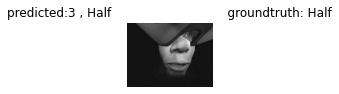

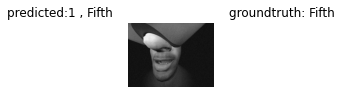

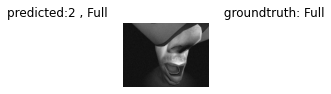

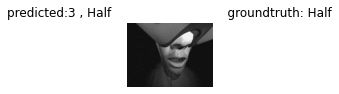

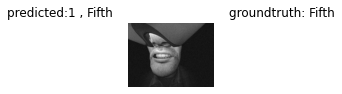

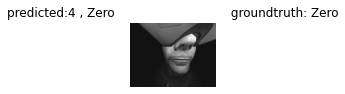

In [21]:
visualize_model(model_ft)

In [17]:
class_names[0]

'Eighty'

In [14]:
model_ft.load_state_dict(torch.load('resnet18.pth')) 

<All keys matched successfully>

In [15]:
model_ft.load_state_dict(torch.load('resnet18Categ.pth')) 

<All keys matched successfully>

In [15]:
 model_ft.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [19]:
yeah = cv2.imread("..\..\yeah.png")

In [122]:
class_names[preds[0]]

'close'

In [66]:
class_names[1]

'open'

In [ ]:
yeah = cv2.imread("..\..\yeah.png")
plt.figure()
#plt.subplot()
#plt.title=class_names[preds[0]]
plt.imshow(yeah)
#plt.axis("off")
#print(class_names[preds[0]])

In [220]:
def OneStopPred(those, model = model_ft,flag = 2,mean =-0.0732,stdev = 0.0437): #(FilePath,model = model_ft):
    #those = cv2.imread(FilePath)

        #print("resized to 320,240 ")
    #print(those.shape)
    #intensity above is in 0,256 integer range manner
    #intensity below is in 0,1 float range manner
    if flag==1:
        if len(those.shape)==3:
            those = (cv2.cvtColor(those, cv2.COLOR_BGR2GRAY))
        if those.shape[0:2]!= (320,240):
            those = cv2.resize(those,(320,240))
        #these = cv2.normalize(those,None,0.0,1.0,cv2.NORM_MINMAX).astype('float32')  # [0,1]
        #print(smean)
        #print(sstd)
        these = (those - smean)/sstd # projected into training distribution
        #these = (these - mean)/stdev
        these -= np.amin(these) #shift to 0 
        #these = cv2.normalize(these,None,0.0,1.0,cv2.NORM_MINMAX).astype('float32') # [0,1]
        #these/=np.amax(these)
        #these = TF.to_tensor(these).unsqueeze(0)
        these = TF.normalize(TF.to_tensor(these.astype('float32')), [0.5], [0.5]).unsqueeze(0) # for the model
        #those = (those - mean)/stdev
        #print("normalize this into training dataset lightness space")
    elif(flag==2):
        print(those.dtype)
        if those.dtype != np.dtype('uint8'):
           those = those.astype('uint8')  
        these = TF.normalize(TF.resize(TF.rgb_to_grayscale(TF.to_tensor(those),
                                                           1), (240,320)),[0.5], [0.5]).unsqueeze(0)

            #transforms class cannot be nested into dataset class
            #to use these indepedently, invoke transforms.functional as TF. most case PIL or Tensor 
            #ToTensor the input image is scaled to [0.0, 1.0] if the np.ndarray dtype = np.uint8
    elif(flag==3):
        #input is np from cv2
        PIL_arr0 = Image.fromarray(np.uint8(those)).convert('RGB')
        these = TF.normalize(TF.to_tensor(TF.resize(TF.rgb_to_grayscale(PIL_arr0
                                                         ,1),(240,320))),[0.5], [0.5]).unsqueeze(0)
        

    print(these.shape)
    with torch.no_grad(): #To perform inference without Gradient Calculation.
        outputs = model_ft(these.cuda())
        _, preds = torch.max(outputs, 1)
    result = class_names[preds[0]]
    print(preds[0].shape, preds[0])
    print(preds[0].cpu().numpy().shape, preds[0].cpu().numpy())
    plt.title = result # does not work???
    #imshow(these[0].cpu().data)
    plt.imshow(those,cmap="gray")
    print(result) # okay... embarras to use it for now
    

## test on 
### 7.1 raw data from leap or png 
### 7.2 processed directly with torch.transform.functional along with PIL
### 7.3 or cv2 preprocess first and then torch.transform.functional 
### 7.4 and different invoking order of  torch.transform.functional 

In [159]:
arr0 = (np.ones((320,240))*255).astype(np.uint8)

situation: a png loaded by cv2 and then to PIL and then processed by TF

In [212]:
PIL_arr0 = Image.fromarray(np.uint8(testR)).convert('RGB')


In [213]:
datasetOrder = TF.normalize(TF.to_tensor(TF.resize(TF.rgb_to_grayscale(PIL_arr0
                                                         ,1),(240,320))),[0.5], [0.5]).unsqueeze(0)

In [214]:
datasetOrder.shape

torch.Size([1, 1, 240, 320])

situation: a png loaded by cv2 and then processed by TF

In [217]:
another = TF.normalize(TF.resize(TF.rgb_to_grayscale(TF.to_tensor(testR),
                                                           1), (240,320)),[0.5], [0.5]).unsqueeze(0)
    

In [218]:
another.shape

torch.Size([1, 1, 240, 320])

In [219]:
torch.equal(datasetOrder,another)

False

In [21]:
test = cv2.imread("../../r3close.png")

In [22]:
shock = cv2.imread("..\..\l2shock.png")

why is it so weird, python window can read two style path........again

In [82]:
teston = test[60:290,20:320]

In [201]:
testR =  test[54:295,365:-10]

In [144]:
testR[0,0]

array([240, 240, 240], dtype=uint8)

In [ ]:
OneStopPred(testR,flag=3)

In [ ]:
OneStopPred(teston,flag=2) 

In [203]:
yeas = shock[60:290,8:325]

In [ ]:
OneStopPred(yeas,flag=3)

In [ ]:
yr = shock[54:297,365:-10]
OneStopPred(yr,flag=3)

In [318]:
#his= cv2.calcHist(cv2.cvtColor(trainsample2, cv2.COLOR_BGR2GRAY),[0],None,[256],(0, 256),accumulate=False)

In [ ]:
#plt.hist(cv2.cvtColor(trainsample2, cv2.COLOR_BGR2GRAY).ravel(),256,[0,256]) # not working!

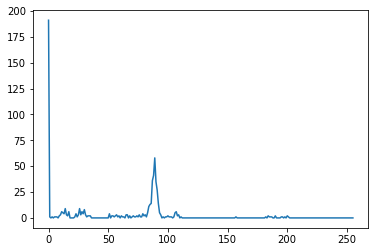

In [314]:
#plt.plot(his)

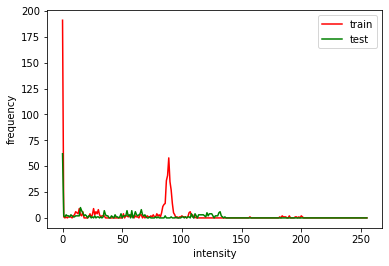

In [320]:
plt.plot(his,color = 'r',label = 'train')
plt.plot(histest,color = 'g',label = 'test')
plt.xlabel("intensity")
plt.ylabel("frequency")
#plt.title("distribution")
plt.legend()
plt.show()

In [224]:
#testoff = cv2.normalize(teston.astype('float32'),0.0,256,cv2.NORM_MINMAX)

In [478]:
yeas.shape

(220, 300, 3)

In [ ]:
ohno = cv2.cvtColor(yeas, cv2.COLOR_BGR2GRAY)
ohno = (ohno - smean)/sstd #recenter to training order
ohno -= np.amin(ohno) #shift to 0 
ohno = cv2.normalize(ohno,None,0,1,cv2.NORM_MINMAX)
plt.imshow(ohno,cmap="gray")
#OneStopPred(ohno,flag=2)

In [24]:
class_names = ['open','close']

below is to calculate a pytorch dataloader mean and std

In [159]:
meann = 0
meansq = 0
std = 0
for data, _ in train_loader:
    #mean = data.mean()
    #meansq = (data**2).mean()
    mean += data.mean()
    std += data.std()
mean /= len(train_loader.dataset)
std  /= len(train_loader.dataset)
#std = torch.sqrt(meansq - mean**2)
print(mean)
print(std)

tensor(-0.0732)
tensor(0.0437)


In [ ]:
datalen=DataMidAugmntedTensor.size(0)
shuffle_list = list(range(0,datalen))
batch_num=int(datalen/batch_size)
random.shuffle(shuffle_list)
real_img=DataMidAugmntedTensor[shuffle_list[i*batch_size:(i+1)*batch_size]].to(device)

In [522]:
OneBatch = next(iter(train_loader))
OneBatch[0].shape

torch.Size([10, 1, 240, 320])